# Import packages

In [1]:
import ast
import math
import numpy as np
import altair as alt
import pandas as pd
import shapely as shp
import geopandas as gpd
from datetime import timedelta, time
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.widgets import Button, Slider, CheckButtons

import itertools
from dijkstar import Graph, find_path

from helper_functions import open_processed_gtfs, open_delays, open_stations

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# Notebook settings

In [2]:
DELAYS_FILEPATH = r'Intermediates\\delays_assigned.csv'
LINKS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_links_corrected.geojson'
STATIONS_FILEPATH = r'Intermediates\\GTFS_20190914\\gtfs_stations_corrected.geojson'
RESULTS_FILEPATH = r'First model results\\D05 to D06.csv'
# RESULTS_ABOVE_ZERO_FILEPATH = r'First model results\\D05 to D06 above zero.csv'


distribution = stats.exponnorm
# distribution_above_zero = stats.halflogistic

column_titles= ['VARIABLE', 'OPTION', 'EXAMPLE VALUE']
variable_names = ['delayed station-direction', 'delay magnitude range', 'delay occurrence time step', 'station-direction to analyse', 'timestep at to analyse']

# Load data

In [3]:
gtfs_stations = open_stations(STATIONS_FILEPATH)
gtfs_stations.head(5)

,stop_id,stop_name,connections,geometry
0,E02,SHAW METRO STATION,"[[E03, E01], [E01, E03]]",POINT (1306094.353 454461.868)
1,D11,CHEVERLY METRO STATION,"[[D10, D12], [D12, D10]]",POINT (1336488.46 455202.936)
2,G02,CAPITOL HEIGHTS METRO STATION,"[[G01, G03], [G03, G01]]",POINT (1337007.377 445376.966)
3,E03,U STREET METRO STATION,"[[E04, E02], [E02, E04]]",POINT (1304034.044 455361.654)
4,D12,LANDOVER METRO STATION,"[[D11, D13], [D13, D11]]",POINT (1343622.123 461562.939)


In [4]:
# delays = open_delays(DELAYS_FILEPATH)

# # Assign dates to delays
# delays['date'] = [date.date() for date in delays['sched_arrival_time']]

# delays.head(3)

In [5]:
results = pd.read_csv(RESULTS_FILEPATH, converters={"connection": eval, "other_connection": eval, 'dist_params': eval})
results.head(5)

,connection,delay_range,timestep,other_connection,future_timestep,dist_params
0,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",5.0,"[1.9363084332005704, -44.1373622808718, 35.677..."
1,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",6.0,"[0.8006572486325675, -32.32943211393756, 53.75..."
2,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",7.0,"[0.6121180864618025, -33.56552270335543, 53.07..."
3,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",8.0,"[1.6210548244218175, -62.26000703681639, 45.26..."
4,"(D05, D06)",0.0,5.0,"(A01/C01, A02)",9.0,"[1.0275163967240994, -62.8695570847448, 50.827..."


# Non-connected

In [6]:
# Settings
current_connection = ('D05', 'D06')
delay_range = 0
other_connection = ('F05', 'F06')
# other_connection = ('D11', 'D12')

In [7]:
test = results[(results['connection'] == current_connection) & \
                (results['other_connection'] == other_connection) & \
                (results['timestep'] == results['future_timestep'])]

plot_data_dict = {}
for delay_range in list(test['delay_range'].unique()):
    if delay_range > 7:
        continue
    test_i = test[test['delay_range'] == delay_range]

    plot_data_dict[delay_range] = {'times': [], 'means': [], 'highs': [], 'lows': []}
    for _, row in test_i.iterrows():
        dist_params = row['dist_params']

        plot_data_dict[delay_range]['times'].append(row['timestep'])
        plot_data_dict[delay_range]['means'].append(distribution.mean(*dist_params))
        plot_data_dict[delay_range]['highs'].append(distribution.ppf(0.975, *dist_params))
        plot_data_dict[delay_range]['lows'].append(distribution.ppf(0.025, *dist_params))

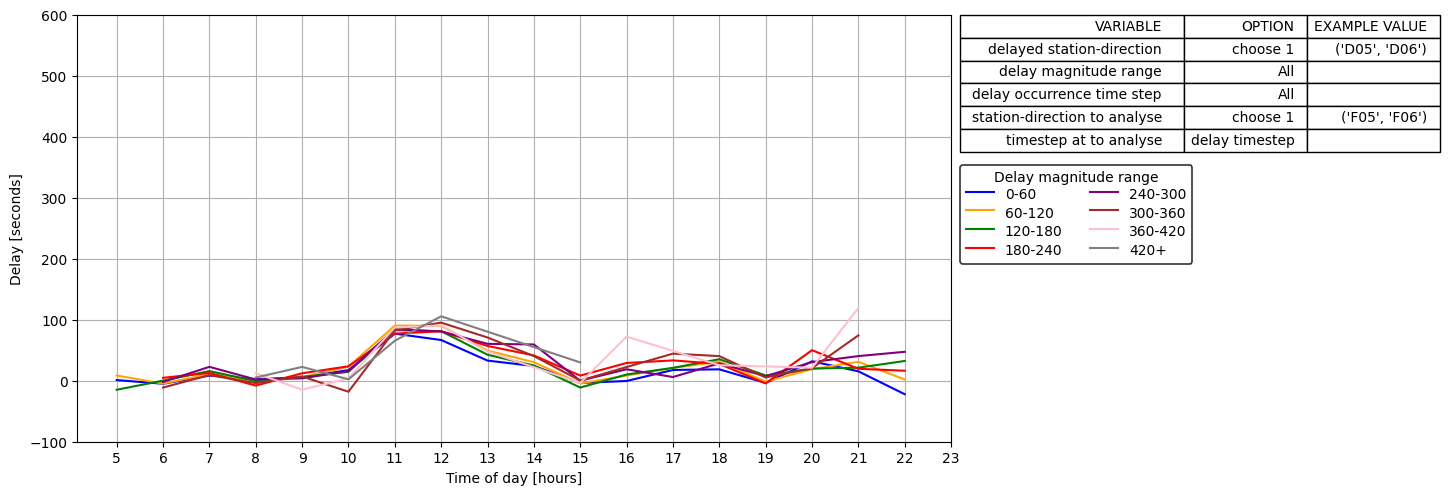

In [8]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for (delay_range, range_data_dict), color in zip(plot_data_dict.items(), colors):
    if delay_range > 7:
        continue
    elif delay_range == 7:
        plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=f"{int(delay_range*60)}+")
    else:
        plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=f"{int(delay_range*60)}-{int((delay_range+1)*60)}")
    # plt.plot(range_data_dict['times'], range_data_dict['lows'], color=color, linestyle='dotted')
    # plt.plot(range_data_dict['times'], range_data_dict['highs'], color=color,  linestyle='--')


legend = plt.legend(bbox_to_anchor=(1.284, 0.665), ncol=2, handleheight=1.6, labelspacing=0.05, title="Delay magnitude range")
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'All', 'All', 'choose 1', 'delay timestep']
values = current_connection, None, None, other_connection, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.55, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))


# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.xticks(np.arange(5, 24, 1))
plt.tight_layout()
plt.grid()
plt.ylim(-100, 600)
# plt.legend()

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_notable_f06.png', dpi=200)

# Connected

In [9]:
# Settings
current_connection = ('D05', 'D06')
delay_range = 0
other_connection = ('D06', 'D07')
# other_connection = ('D11', 'D12')

In [10]:
test = results[(results['connection'] == current_connection) & \
                (results['other_connection'] == other_connection) & \
                (results['timestep'] == results['future_timestep'])]

plot_data_dict = {}
for delay_range in list(test['delay_range'].unique()):
    if delay_range > 7:
        continue
    test_i = test[test['delay_range'] == delay_range]

    plot_data_dict[delay_range] = {'times': [], 'means': [], 'highs': [], 'lows': []}
    for _, row in test_i.iterrows():
        dist_params = row['dist_params']

        plot_data_dict[delay_range]['times'].append(row['timestep'])
        plot_data_dict[delay_range]['means'].append(distribution.mean(*dist_params))
        plot_data_dict[delay_range]['highs'].append(distribution.ppf(0.975, *dist_params))
        plot_data_dict[delay_range]['lows'].append(distribution.ppf(0.025, *dist_params))

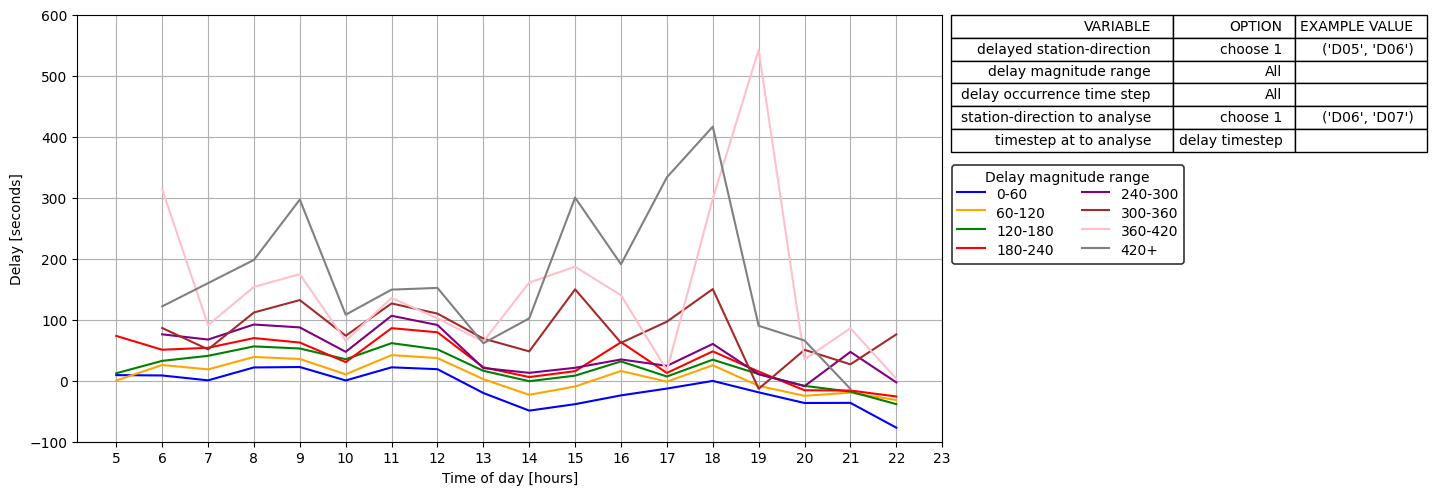

In [11]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for (delay_range, range_data_dict), color in zip(plot_data_dict.items(), colors):
    if delay_range > 7:
        continue
    elif delay_range == 7:
        plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=f"{int(delay_range*60)}+")
    else:
        plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=f"{int(delay_range*60)}-{int((delay_range+1)*60)}")
    # plt.plot(range_data_dict['times'], range_data_dict['lows'], color=color, linestyle='dotted')
    # plt.plot(range_data_dict['times'], range_data_dict['highs'], color=color,  linestyle='--')


legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title="Delay magnitude range")
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'All', 'All', 'choose 1', 'delay timestep']
values = current_connection, None, None, other_connection, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.55, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))


# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.xticks(np.arange(5, 24, 1))
plt.tight_layout()
plt.grid()
plt.ylim(-100, 600)
# plt.legend()

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_notable_d06png', dpi=200)

# Further removed

In [12]:
# Settings
current_connection = ('D05', 'D06')
delay_range = 0
other_connection = ('D08', 'D09')
# other_connection = ('D11', 'D12')

In [13]:
test = results[(results['connection'] == current_connection) & \
                (results['other_connection'] == other_connection) & \
                (results['timestep'] == results['future_timestep'])]

plot_data_dict = {}
for delay_range in list(test['delay_range'].unique()):
    if delay_range > 7:
        continue
    test_i = test[test['delay_range'] == delay_range]

    plot_data_dict[delay_range] = {'times': [], 'means': [], 'highs': [], 'lows': []}
    for _, row in test_i.iterrows():
        dist_params = row['dist_params']

        plot_data_dict[delay_range]['times'].append(row['timestep'])
        plot_data_dict[delay_range]['means'].append(distribution.mean(*dist_params))
        plot_data_dict[delay_range]['highs'].append(distribution.ppf(0.975, *dist_params))
        plot_data_dict[delay_range]['lows'].append(distribution.ppf(0.025, *dist_params))

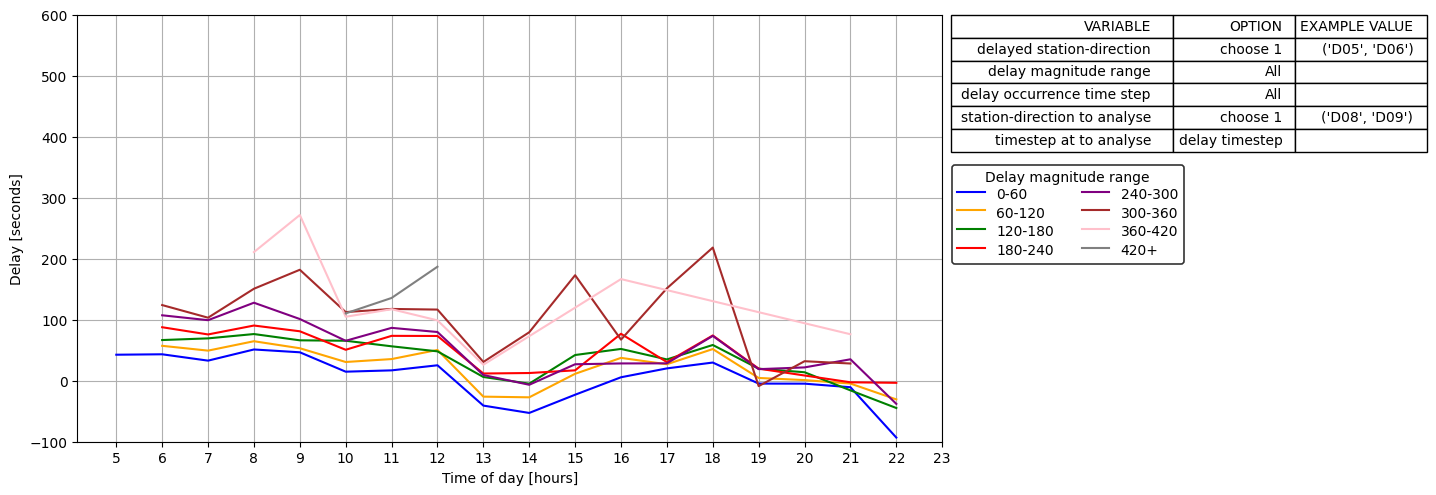

In [14]:
fig = plt.figure(figsize=(17, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for (delay_range, range_data_dict), color in zip(plot_data_dict.items(), colors):
    if delay_range > 7:
        continue
    elif delay_range == 7:
        plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=f"{int(delay_range*60)}+")
    else:
        plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=f"{int(delay_range*60)}-{int((delay_range+1)*60)}")
    # plt.plot(range_data_dict['times'], range_data_dict['lows'], color=color, linestyle='dotted')
    # plt.plot(range_data_dict['times'], range_data_dict['highs'], color=color,  linestyle='--')


legend = plt.legend(bbox_to_anchor=(1.003, 0.665),  ncol=2,handleheight=1.6, labelspacing=0.05, title="Delay magnitude range")
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.2)

options = ['choose 1', 'All', 'All', 'choose 1', 'delay timestep']
values = current_connection, None, None, other_connection, None
cell_texts = [column_titles] + [[name, option, value] for name, option, value in zip(variable_names, options, values)]

the_table = plt.table(cellText=cell_texts, loc='center right', bbox=[1.01, 0.68, 0.55, 0.32])
the_table.auto_set_font_size(False)
the_table.auto_set_column_width(col=list(range(3)))


# plt.title(f"Confidence interval for delays at {other_connection[0]} in the direction of {other_connection[1]} \n given a {delay_range}-{delay_range+1} minute delay at {current_connection[0]} in the direction of {current_connection[1]}")
plt.xlabel('Time of day [hours]')
plt.ylabel('Delay [seconds]')
plt.xticks(np.arange(5, 24, 1))
plt.tight_layout()
plt.grid()
plt.ylim(-100, 600)
# plt.legend()

fig.savefig(r'C:\Users\lange\OneDrive\Documenten\Jaar_6-Msc_CE_TTE\Thesis\Codebase\Codebase figures\first_model_notable_d08.png', dpi=200)

In [15]:
selected_time = 8
test = results[(results['connection'] == current_connection) & \
               (results['timestep'] == selected_time)  & \
                (results['other_connection'] == other_connection)]

plot_data_dict = {}
for delay_range in list(test['delay_range'].unique()):
    if delay_range > 7:
        continue
    test_i = test[test['delay_range'] == delay_range]
    
    plot_data_dict[delay_range] = {'times': [], 'means': [], 'highs': [], 'lows': []}
    for _, row in test_i.iterrows():
        dist_params = row['dist_params']

        plot_data_dict[delay_range]['times'].append(row['future_timestep'])
        plot_data_dict[delay_range]['means'].append(distribution.mean(*dist_params))
        plot_data_dict[delay_range]['highs'].append(distribution.ppf(0.975, *dist_params))
        plot_data_dict[delay_range]['lows'].append(distribution.ppf(0.025, *dist_params))

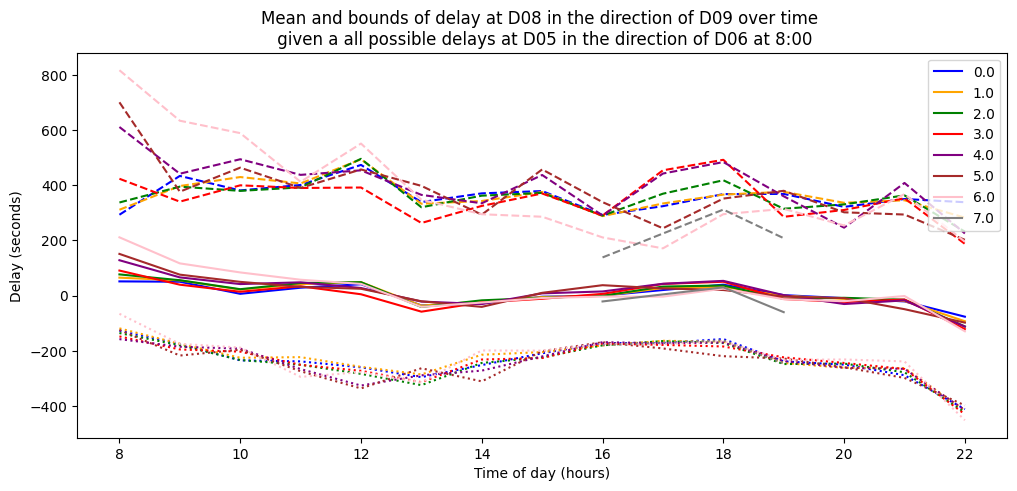

In [16]:
plt.figure(figsize=(12, 5))
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'navy', 'lime', 'magenta', 'gold', 'black', 'sandybrown', 'red']

for (delay_range, range_data_dict), color in zip(plot_data_dict.items(), colors):

    plt.plot(range_data_dict['times'], range_data_dict['means'], color=color, label=delay_range)
    plt.plot(range_data_dict['times'], range_data_dict['lows'], color=color, linestyle='dotted')
    plt.plot(range_data_dict['times'], range_data_dict['highs'], color=color,  linestyle='--')


    # for time, mean, low, high in zip(range_data_dict['times'], range_data_dict['means'], range_data_dict['lows'], range_data_dict['highs']):
    #     if time == range_data_dict['times'][0]:
    #         plt.hlines(mean, time, time+1, color, label=delay_range)
    #     else:
    #         plt.hlines(mean, time, time+1, color)
        
    #     # plt.fill_between(x=[time, time+1], y1=[low, low], y2=[high, high], color=color, alpha=0.2, linewidth=0)
    #     plt.hlines(high, time, time+1, color, alpha=0.5)
    #     plt.hlines(low, time, time+1, color, alpha=0.5)

plt.title(f"Mean and bounds of delay at {other_connection[0]} in the direction of {other_connection[1]} over time \n given a all possible delays at {current_connection[0]} in the direction of {current_connection[1]} at {selected_time}:00")
plt.xlabel('Time of day (hours)')
plt.ylabel('Delay (seconds)')
plt.legend()